In [1]:
%pip install -qU "airavata-python-sdk[notebook]"
import airavata_jupyter_magic

%authenticate
%request_runtime hpc_cpu --file=cybershuttle.yml --walltime=60 --use=NeuroData25VC1:cloud
%wait_for_runtime hpc_cpu --live
%switch_runtime hpc_cpu

Note: you may need to restart the kernel to use updated packages.

Loaded airavata_jupyter_magic (2.1.4.post4) 
(current runtime = local)

  %authenticate                              -- Authenticate to access high-performance runtimes.
  %request_runtime <rt> [args]               -- Request a runtime named <rt> with configuration <args>.
                                                Call multiple times to request multiple runtimes.
  %restart_runtime <rt>                      -- Restart runtime <rt> if it hangs. This will clear all variables.
  %stop_runtime <rt>                         -- Stop runtime <rt> when no longer needed.
  %wait_for_runtime <rt>                     -- Wait for runtime <rt> to be ready.
  %switch_runtime <rt>                       -- Switch the active runtime to <rt>. All subsequent cells will run here.
  %%run_on <rt>                              -- Force a cell to always execute on <rt>, regardless of the active runtime.
  %stat_runtime <rt>               

Output()

Authenticated.

Requesting runtime=hpc_cpu...
[NeuroData25VC1:cloud, 60 Minutes, 1 Node(s), 4 CPU(s), 0 GPU(s), 4096 MB RAM, 1024 MB VRAM]
* modules=[]
* libraries=['python=3.10', 'pip', 'ipywidgets', 'seaborn']
* pip=['git+https://github.com/cyber-shuttle/onehot-hmmglm#subdirectory=hmmglm']
* mounts=['brainml-onehot-hmmglm:/cybershuttle_data/brainml-onehot-hmmglm']
Requested runtime=hpc_cpu
Request successful: runtime=hpc_cpu


Output()

local:/var/folders/_n/fcf6nx4j67gbbt4_8mjqxdc80000gn/T/connection_byu8imio.json --> hpc_cpu:connection_byu8imio.json... [200]
started proc_name=hpc_cpu_kernel on rt=hpc_cpu. pid=4095
forwarding ports=[17030, 17031, 17032, 17033, 17034]
hpc_cpu:17030 -> access via 18.118.140.230:10000
hpc_cpu:17031 -> access via 18.118.140.230:10001
hpc_cpu:17032 -> access via 18.118.140.230:10002
hpc_cpu:17033 -> access via 18.118.140.230:10003
hpc_cpu:17034 -> access via 18.118.140.230:10004
started ipykernel tunnels for hpc_cpu at 18.118.140.230
started ipykernel client for hpc_cpu
Remote Jupyter kernel launched and connected for runtime=hpc_cpu.
Switched to runtime=hpc_cpu.


# One-hot HMM-GLM on the CRCRS pfc-6 Dataset

![](../assets/schematic.png)

## 1 Load the dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from matplotlib.patches import Circle, Wedge
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from hmmglm.models import onehot
from hmmglm import distributions, inference

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [3]:
def load_data(dt: float = 20, T: float = 15000):
    n_time_bins = int(T / dt)
    session = "200104"
    behavior = pd.read_csv(
        f"cybershuttle_data/brainml-onehot-hmmglm/{session}/{session}_Behavior.dat",
        sep="\t",
        header=None,
    )
    behavior.columns = [
        "trial_start_time",
        "trial_end_time",
        "rule",
        "outcome",
        "choice",
        "light_position",
    ]
    behavior.replace(
        {
            "rule": {
                1: "go right",
                2: "go light",
                3: "go left",
                4: "go dark",
            },
            "outcome": {1: "correct", 0: "incorrect"},
            "choice": {1: "left", 0: "right"},
            "light_position": {1: "left", 0: "right"},
        },
        inplace=True,
    )

    raw_position = pd.read_table(
        f"cybershuttle_data/brainml-onehot-hmmglm/{session}/{session}_Pos.dat", header=None
    )
    raw_position.columns = ["time", "x", "y"]
    raw_spike_data = pd.read_table(
        f"cybershuttle_data/brainml-onehot-hmmglm/{session}/{session}_SpikeData.dat", header=None
    )
    raw_spike_data.columns = ["time", "cell_id"]

    spike_time_by_cell_id = [
        (neuron, i["time"].values)
        for neuron, i in raw_spike_data.groupby("cell_id")
    ]
    n_neurons = len(spike_time_by_cell_id)
    n_trials = len(behavior)

    start_idx_list = np.searchsorted(
        raw_position["time"], behavior["trial_start_time"] - 5000
    )
    end_idx_list = np.searchsorted(
        raw_position["time"], behavior["trial_start_time"] - 5000 + T
    )
    trial_start_idx_list = np.searchsorted(
        raw_position["time"], behavior["trial_start_time"]
    )
    trial_end_idx_list = np.searchsorted(
        raw_position["time"], behavior["trial_end_time"]
    )

    behavior["trajectory"] = None
    behavior["trial_start_position"] = None
    behavior["trial_end_position"] = None
    spikes = torch.zeros((n_trials, n_time_bins, n_neurons))
    for trial in range(n_trials):
        time_bins = np.linspace(
            behavior.at[trial, "trial_start_time"] - 5000,
            behavior.at[trial, "trial_start_time"] - 5000 + T,
            n_time_bins + 1,
        )
        for neuron in range(n_neurons):
            spikes[trial, :, neuron] = torch.tensor(
                np.histogram(
                    spike_time_by_cell_id[neuron][1],
                    bins=time_bins,
                )[0]
            )
        
        behavior.at[trial, "trajectory"] = raw_position.iloc[
            start_idx_list[trial] : end_idx_list[trial]
        ][["time", "x", "y"]].values
        behavior.at[trial, "trial_start_position"] = raw_position.iloc[
            trial_start_idx_list[trial]
        ][["x", "y"]].values
        behavior.at[trial, "trial_end_position"] = raw_position.iloc[
            trial_end_idx_list[trial]
        ][["x", "y"]].values
    spikes = spikes.to(
        torch.float32
    )  # (n_trials, n_time_bins, n_neurons)
    return spikes, behavior

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [4]:
spikes, behavior = load_data()
print(spikes.shape)
behavior.head()

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
torch.Size([54, 750, 18])


,trial_start_time,trial_end_time,rule,outcome,choice,light_position,trajectory,trial_start_position,trial_end_position
0,1968759.3,1971595.3,go dark,incorrect,left,left,"[[1963787.9, 173.2, 187.2], [1963821.3, 173.0,...","[169.4, 134.2]","[257.1, 49.1]"
1,1993249.2,1996285.4,go dark,incorrect,left,left,"[[1988277.8, 155.8, 163.1], [1988311.2, 155.9,...","[168.1, 135.9]","[254.9, 47.9]"
2,2005927.9,2014169.0,go dark,incorrect,left,left,"[[2000956.5, 147.1, 92.3], [2000989.9, 146.5, ...","[176.1, 204.8]","[254.0, 46.1]"
3,2023611.3,2033854.4,go dark,correct,left,right,"[[2018639.9, 119.3, 81.6], [2018673.3, 118.8, ...","[182.4, 184.7]","[255.8, 46.2]"
4,2093010.5,2096880.8,go dark,incorrect,left,left,"[[2088039.1, 173.8, 192.2], [2088072.5, 174.6,...","[152.9, 129.2]","[255.1, 44.4]"


cell finished on hpc_cpu.


## 2 Configure the One-hot HMM-GLM

In [5]:
n_trials, n_time_bins, n_neurons = spikes.shape
n_states = 4
kernel_size = 5

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [6]:
torch.manual_seed(0)

decoder = onehot.OneHotHMMGLM(
    n_states=n_states,
    n_neurons=n_neurons,
    kernel_size=kernel_size,
    activation="softplus",  # or "sigmoid", etc
    share_bias=False,  # 4 states dont' share the same bias vector
    share_kernel=True,  # 4 states share the same kernel
    diag_setting="none",  # don't treat diagonal elements differently
    adjacency_distribution="categorical",  # or "gumbel-softmax"
    adjacency_exists=True,  # adjacency is the one-hot encoding of [inh, no, exc] rather than [inh, exc]
)

# decoder = onehot.OneHotHMMGLM(
#     n_states=n_states,
#     n_neurons=n_neurons,
#     kernel_size=kernel_size,
#     activation="softplus",  # or "sigmoid", etc
#     share_bias=False,
#     share_kernel=False,
#     diag_setting="free",  # don't treat diagonal elements differently
#     adjacency_distribution="categorical",  # or "gumbel-softmax"
#     adjacency_exists=True,  # adjacency is the one-hot encoding of [inh, no, exc] rather than [inh, exc]
# )

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


Let's also fix the convolution kernel for simplicity.

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...


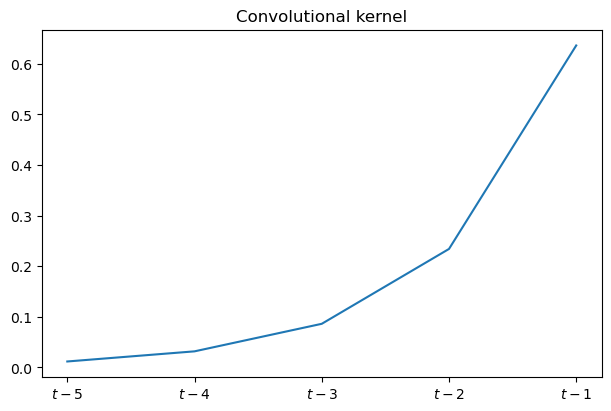

cell finished on hpc_cpu.


In [7]:
kernel = torch.exp(-torch.arange(5)).flip(dims=(-1,))
kernel = kernel / kernel.sum()

fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")
ax.plot(kernel)
ax.set(
    xticks=[0, 1, 2, 3, 4],
    xticklabels=["$t-5$", "$t-4$", "$t-3$", "$t-2$", "$t-1$"],
    title="Convolutional kernel",
)

kernel = kernel.unsqueeze(0).unsqueeze(0).expand_as(decoder.conv_weight).contiguous()  # (shared across states, n_neurons, n_neurons, kernel_size)
decoder.conv_weight = kernel  # set the kernel
decoder.parametrizations.conv_weight.original.requires_grad = False  # freeze the kernel

## 3 Train One-hot HMM-GLM

In [8]:
def train_onehot_hmmglm(
    decoder: onehot.OneHotHMMGLM,
    optimizer: torch.optim.Optimizer,
    spikes: torch.FloatTensor,
    n_epochs: int = 100,
    forward_backward_every_n_epochs: int = 1,
    print_freq: int = 1,
) -> torch.FloatTensor:
    
    n_trials, n_time_bins, n_neurons = spikes.shape

    gamma_list = [None for _ in range(n_trials)]
    xi_list = [None for _ in range(n_trials)]

    df_log = pd.DataFrame(index=range(n_epochs), columns=["loss", "conditional_log_prob", "expected_log_prob", "adjacency_log_prob", "adjacency_entropy"])

    for epoch in range(n_epochs):
        for trial in range(n_trials):
            x = spikes[trial]  # (n_time_bins, n_neurons)
            x_pred_mean = decoder(x)  # (n_states, n_time_bins, n_neurons)
            emission_log_prob = distributions.poisson_log_likelihood(
                x[None, :, :], x_pred_mean
            ).sum(dim=-1).T  # (n_time_bins, n_states)

            if epoch % forward_backward_every_n_epochs == 0:
                gamma_list[trial], xi_list[trial] = inference.forward_backward(
                    emission_log_prob, decoder.transition_matrix, algorithm="logsumexp"
                )
            
            expected_log_prob = (
                    inference.baum_welch(
                    emission_log_prob,
                    decoder.transition_matrix,
                    gamma_list[trial],
                    xi_list[trial],
                )
                / x.shape[0]
            )

            adjacency = decoder.adjacency
            log_adjacency = F.log_softmax(
                decoder.parametrizations["adjacency"].original, dim=-1
            )

            if decoder.adjacency_distribution == "gumbel-softmax":
                logit_adjacency_prior = decoder.logit_adjacency_prior.expand_as(
                    log_adjacency
                )
                adjacency_log_prob = distributions.gumbel_softmax_log_likelihood_log_input(
                    log_adjacency,
                    logit_adjacency_prior,
                    tau=0.5,
                ).sum()
            elif decoder.adjacency_distribution == "categorical":
                log_adjacency_prior = F.log_softmax(
                    decoder.logit_adjacency_prior, dim=-1
                ).expand_as(adjacency)
                adjacency_log_prob = (adjacency * log_adjacency_prior).sum()
            else:
                raise ValueError(
                    f"Invalid adjacency_distribution: {decoder.adjacency_distribution}"
                )
            
            adjacency_entropy = -(adjacency * log_adjacency).sum()

            loss = -expected_log_prob - adjacency_log_prob
            if decoder.adjacency_distribution == "categorical":
                loss += adjacency_entropy
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            df_log.at[epoch, "loss"] = loss.item() / n_trials
            df_log.at[epoch, "conditional_log_prob"] = (
                emission_log_prob[torch.arange(n_time_bins), gamma_list[trial].argmax(dim=-1)].sum().item() / n_trials
            )
            df_log.at[epoch, "expected_log_prob"] = expected_log_prob.item() / n_trials
            df_log.at[epoch, "adjacency_log_prob"] = adjacency_log_prob.item() / n_trials
            df_log.at[epoch, "adjacency_entropy"] = adjacency_entropy.item() / n_trials
        
        decoder.parametrizations["adjacency"].original.data = F.log_softmax(
            decoder.parametrizations["adjacency"].original.data, dim=-1
        ).clamp(-20, 0)
        
        if epoch % print_freq == 0:
            print(epoch, df_log.loc[epoch], flush=True)
    
    return df_log

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [9]:
optimizer = torch.optim.AdamW(
    decoder.parameters(),
    lr=1e-2,
)
n_epochs = 100
forward_backward_every_n_epochs = 4

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [10]:
df_log = train_onehot_hmmglm(
    decoder,
    optimizer,
    spikes,
    n_epochs=n_epochs,
    forward_backward_every_n_epochs=forward_backward_every_n_epochs,
    print_freq=1,
)

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
0 loss                     46.500524
conditional_log_prob   -117.435872
expected_log_prob        -0.159457
adjacency_log_prob      -23.444359
adjacency_entropy         22.89671
Name: 0, dtype: object
1 loss                    28.511088
conditional_log_prob   -91.784324
expected_log_prob       -0.124876
adjacency_log_prob     -14.474306
adjacency_entropy       13.911906
Name: 1, dtype: object
2 loss                    15.151794
conditional_log_prob   -83.162109
expected_log_prob       -0.113487
adjacency_log_prob      -7.736981
adjacency_entropy        7.301326
Name: 2, dtype: object
3 loss                     8.777377
conditional_log_prob   -80.511692
expected_log_prob       -0.109961
adjacency_log_prob      -4.578886
adjacency_entropy        4.088531
Name: 3, dtype: object
4 loss                     5.475431
conditional_log_prob   -73.117219
expected_log_prob       -0.098535
adjacency_log_prob      -2.957506
adjacen

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...


Text(0.5, 0.01, 'Epoch')

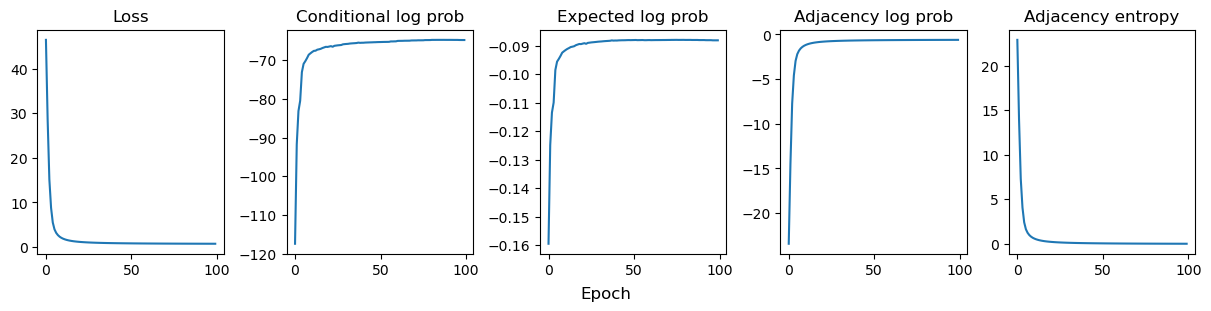

cell finished on hpc_cpu.


In [11]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), layout="constrained")
axs[0].plot(df_log["loss"])
axs[0].set_title("Loss")
axs[1].plot(df_log["conditional_log_prob"])
axs[1].set_title("Conditional log prob")
axs[2].plot(df_log["expected_log_prob"])
axs[2].set_title("Expected log prob")
axs[3].plot(df_log["adjacency_log_prob"])
axs[3].set_title("Adjacency log prob")
axs[4].plot(df_log["adjacency_entropy"])
axs[4].set_title("Adjacency entropy")
fig.supxlabel("Epoch")

In [12]:
torch.save(decoder.state_dict(), "onehot_decoder.pt")

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


## 4 Check and visualize the result

In [13]:
decoder.load_state_dict(torch.load("onehot_decoder.pt"))

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...


<All keys matched successfully>

cell finished on hpc_cpu.


executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...


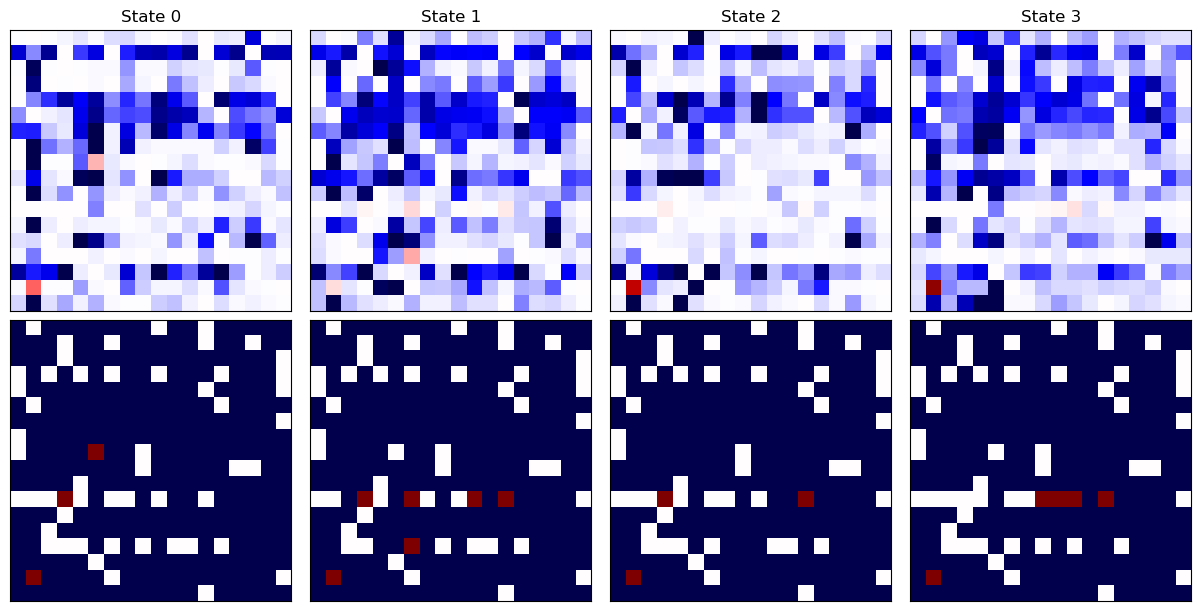

cell finished on hpc_cpu.


In [14]:
with torch.no_grad():
    decoder.eval()
    weight = decoder.weight
    # weight[:, torch.arange(n_neurons), torch.arange(n_neurons)] = (
    #     decoder.diag.weight.mean(dim=-1).reshape(-1, n_neurons)
    # )
    adjacency = decoder.adjacency.argmax(dim=-1) - 1

    fig, axs = plt.subplots(2, 4, figsize=(12, 6), layout="constrained")
    for state in range(n_states):
        ax = axs[0, state]
        ax.matshow(weight[state], vmin=-5, vmax=5, cmap="seismic")
        ax.set_title(f"State {state}")
        ax.set(xticks=[], yticks=[])

        ax = axs[1, state]
        ax.matshow(adjacency[state], vmin=-1, vmax=1, cmap="seismic")
        ax.set(xticks=[], yticks=[])

In [16]:
def plot_frame(ax):
    transform = np.array([[-1 / 2, np.sqrt(3) / 2], [-np.sqrt(3) / 2, -1 / 2]])
    radius = 40
    theta = 210 / 360 * 2 * np.pi
    start = np.array([radius * np.cos(theta), radius * np.sin(theta)])
    arm_length = 125
    theta = 330 / 360 * 2 * np.pi
    end = np.array([radius * np.cos(theta), radius * np.sin(theta)])
    one_arm = np.array(
        [
            [start[0], start[0], end[0], end[0]],
            [start[1], start[1] - arm_length, end[1] - arm_length, end[1]],
        ]
    )
    ax.plot(one_arm[0], one_arm[1], "k")
    one_arm = transform @ one_arm
    ax.plot(one_arm[0], one_arm[1], "k")
    one_arm = transform @ one_arm
    ax.plot(one_arm[0], one_arm[1], "k")

    # ax.text(0, -160, "root", fontsize=15, va="center", ha="center")
    ax.set_xlim(-160, 160)
    ax.set_ylim(-190, 130)
    ax.axis("off")
    ax.set_aspect("equal")


def plot_states(ax, behavior_ser, inferred_states, markersize: int = 6):
    trajectory_time = behavior_ser["trajectory"][:, 0]
    ax.matshow(inferred_states[None, :], vmin=0, vmax=9, cmap="tab10", aspect="auto")
    ax.set(xticks=[], yticks=[])

    if behavior_ser["outcome"] == "correct":
        marker = "*k"
    else:
        marker = "sk"

    trial_start_idx = (
        np.searchsorted(trajectory_time, behavior_ser["trial_start_time"])
        / len(trajectory_time)
        * len(inferred_states)
    )
    trial_end_idx = (
        np.searchsorted(trajectory_time, behavior_ser["trial_end_time"])
        / len(trajectory_time)
        * len(inferred_states)
    )
    ax.plot(trial_start_idx, 0, ">k", markersize=markersize)
    ax.plot(trial_end_idx, 0, marker, markersize=markersize)


def plot_soft_states(ax, behavior_ser, gamma, markersize: int = 6):
    trajectory_time = behavior_ser["trajectory"][:, 0]
    n_states = gamma.shape[1]
    for state in range(n_states):
        ax.matshow(
            state * np.ones((1, gamma.shape[0])),
            vmin=0,
            vmax=9,
            cmap="tab10",
            aspect="auto",
            alpha=gamma[None, :, state],
        )
    ax.set(xticks=[], yticks=[])

    if behavior_ser["outcome"] == "correct":
        marker = "*k"
    else:
        marker = "sk"

    trial_start_idx = (
        np.searchsorted(trajectory_time, behavior_ser["trial_start_time"])
        / len(trajectory_time)
        * len(gamma)
    )
    trial_end_idx = (
        np.searchsorted(trajectory_time, behavior_ser["trial_end_time"])
        / len(trajectory_time)
        * len(gamma)
    )
    ax.plot(trial_start_idx, 0, ">k", markersize=markersize)
    ax.plot(trial_end_idx, 0, marker, markersize=markersize)


def plot_trajectory(
    ax, behavior_ser: pd.Series, inferred_states: torch.Tensor, n_points: int | None = None, truncate: tuple[int|None, int|None] = (0, -1), markersize: int = 10
):
    theta = 185 / 360 * 2 * np.pi
    transform = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )
    translation = np.array([155, 122])
    trial_start_position = behavior_ser["trial_start_position"]
    trial_start_position = transform @ trial_start_position + translation
    ax.plot(
        trial_start_position[0],
        trial_start_position[1],
        ">k",
        markersize=markersize,
    )
    if behavior_ser["outcome"] == "correct":
        marker = "*k"
    else:
        marker = "sk"
    if behavior_ser["light_position"] == "right":
        ax.add_patch(Circle((140, 90), 10, fc="gold", edgecolor="black"))
        ax.add_patch(Wedge((140, 80), 5, 180, 360, fc="none", edgecolor="black"))
    else:
        ax.add_patch(Circle((-140, 90), 10, fc="gold", edgecolor="black"))
        ax.add_patch(Wedge((-140, 80), 6, 180, 360, fc="none", edgecolor="black"))
    trial_end_position = behavior_ser["trial_end_position"]
    trial_end_position = transform @ trial_end_position + translation
    ax.plot(
        trial_end_position[0],
        trial_end_position[1],
        marker,
        markersize=markersize,
    )
    ax.text(0, 90, f"{behavior_ser['rule']}", fontsize=15, ha="center", va="center")

    trajectory = behavior_ser["trajectory"][:, 1:]

    if n_points is None:
        n_points = min(len(trajectory), len(inferred_states))
    trajectory = trajectory[np.linspace(0, len(trajectory) - 1, n_points, dtype=int)]
    trajectory = trajectory @ transform.T + translation
    inferred_states = inferred_states[
        np.linspace(0, len(inferred_states) - 1, n_points, dtype=int)
    ]
    ax.scatter(
        trajectory[truncate[0]:truncate[1], 0],
        trajectory[truncate[0]:truncate[1], 1],
        c=inferred_states[truncate[0]:truncate[1]],
        vmin=0,
        vmax=9,
        cmap="tab10",
        s=1,
        zorder=10,
    )

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...


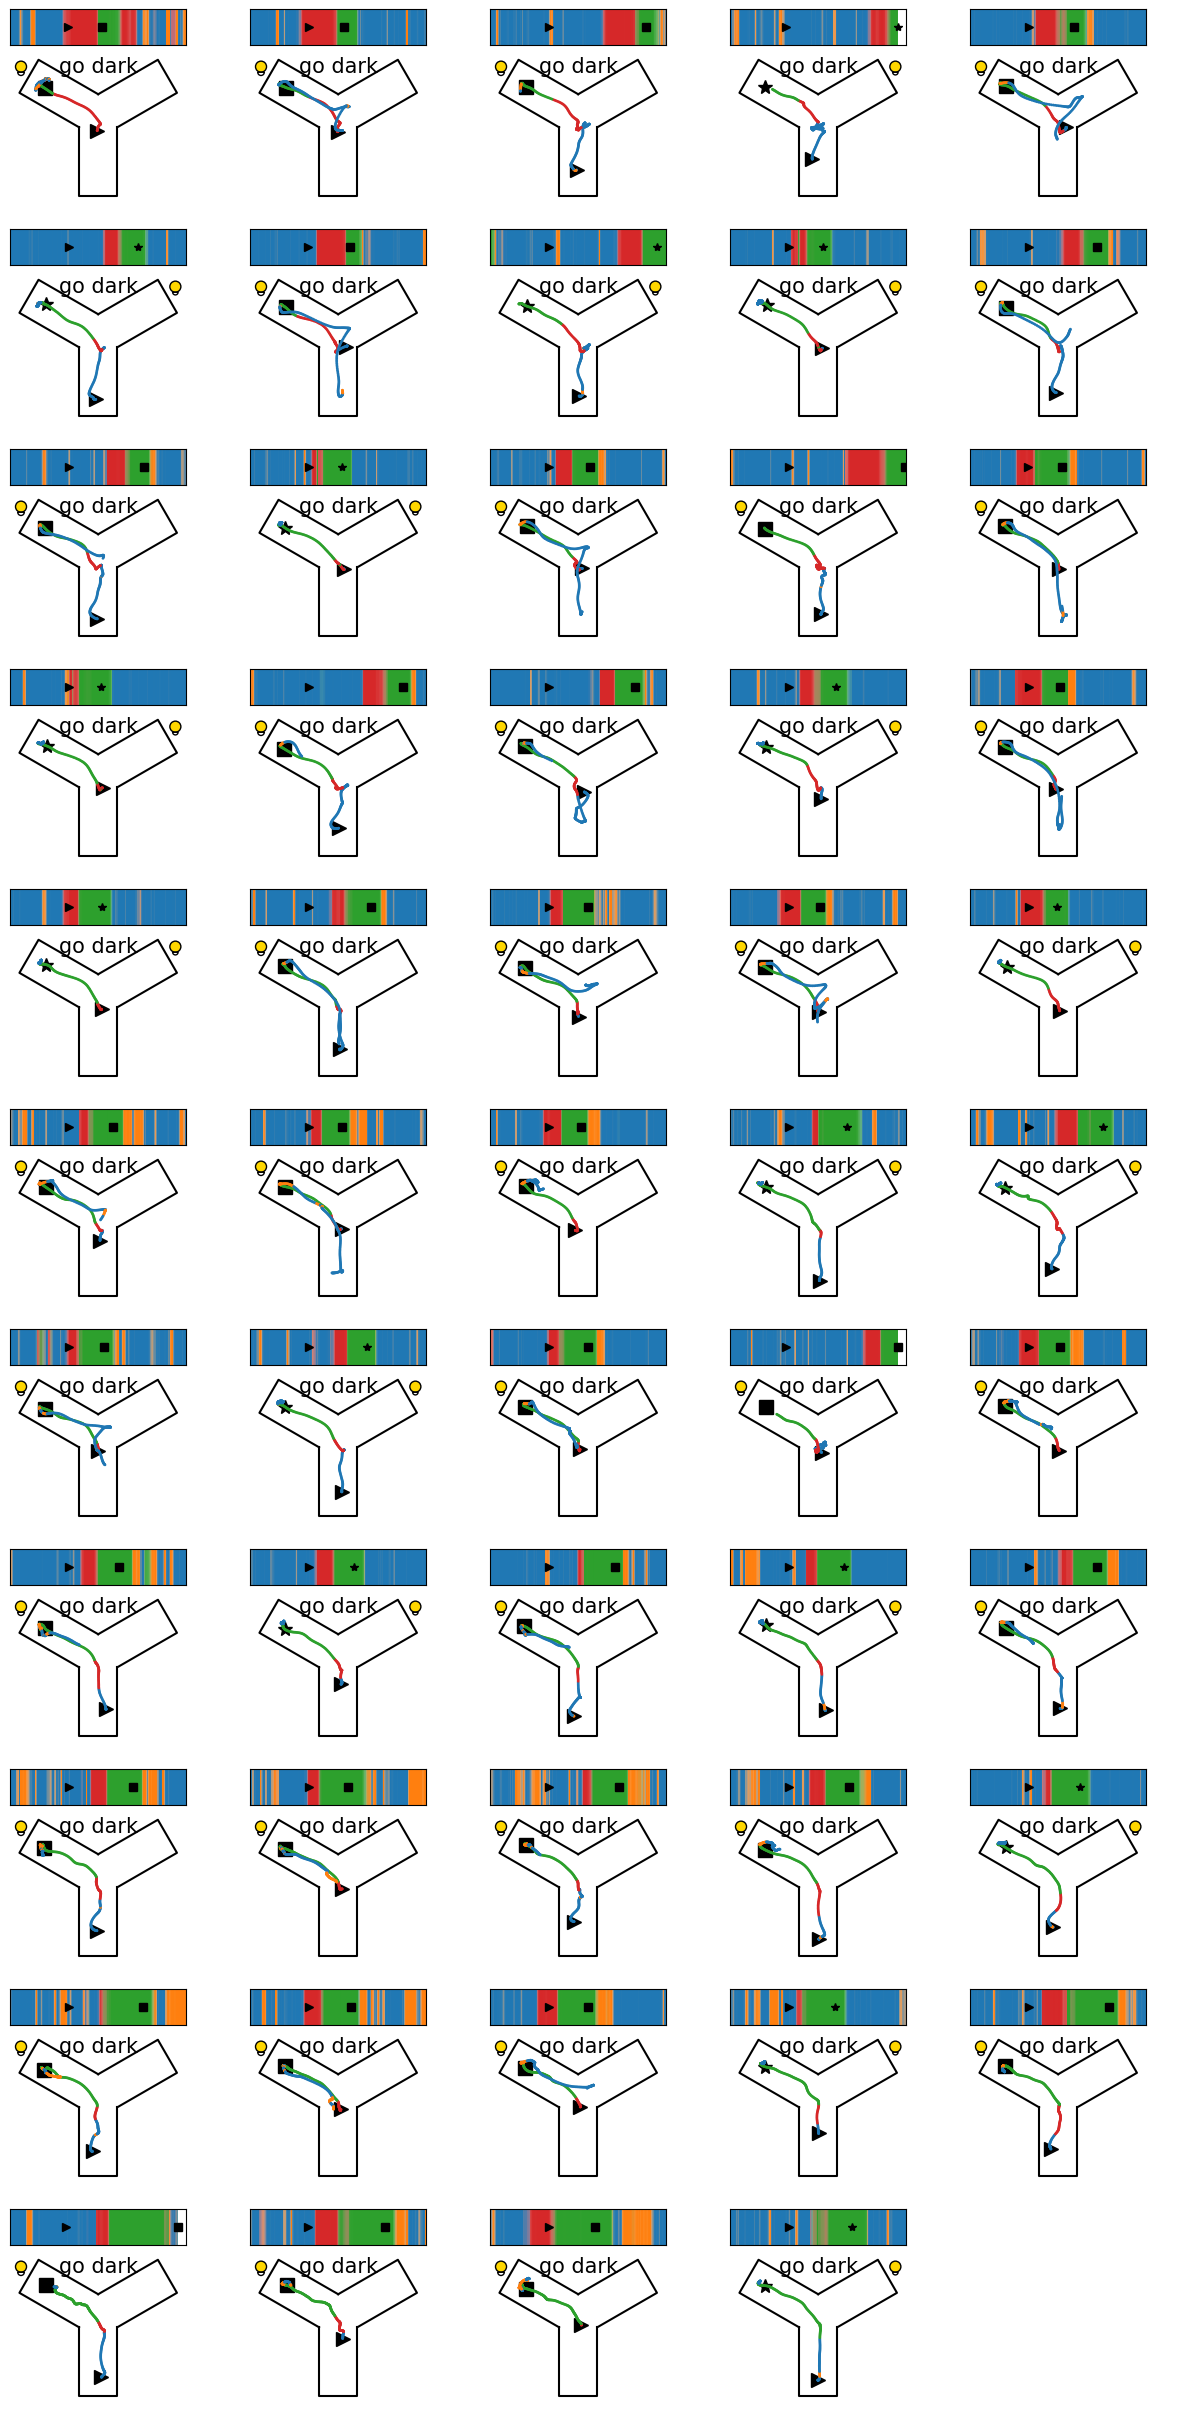

cell finished on hpc_cpu.


In [17]:
n_rows = (n_trials - 1) // 5 + 1
n_points = 450
fig, axs = plt.subplots(n_rows, 5, figsize=(12, 2.2 * n_rows), layout="constrained")
axs = axs.flatten()

gamma_list = [None for _ in range(n_trials)]
inferred_states_list = [None for _ in range(n_trials)]

with torch.no_grad():
    for trial in range(n_trials):
    # for trial in range(5):
        x = spikes[trial]  # (n_time_bins, n_neurons)
        x_pred_mean = decoder(x)  # (n_states, n_time_bins, n_neurons)
        emission_log_prob = distributions.poisson_log_likelihood(
            x[None, :, :], x_pred_mean
        ).sum(dim=-1).T  # (n_time_bins, n_states)

        gamma_list[trial], _ = inference.forward_backward(
            emission_log_prob, decoder.transition_matrix, algorithm="logsumexp"
        )
        inferred_states_list[trial] = inference.viterbi(
            emission_log_prob, decoder.transition_matrix
        )
        ax = axs[trial]
        plot_frame(ax)
        plot_trajectory(ax, behavior.loc[trial], inferred_states_list[trial], n_points=n_points, truncate=(150, -1))
        ax_divider = make_axes_locatable(ax)
        ax_states = ax_divider.append_axes("top", size="20%", pad=0)
        plot_soft_states(ax_states, behavior.loc[trial], gamma_list[trial])
        # plot_states(ax_states, behavior.loc[trial], inferred_states_list[trial])


    for trial in range(n_trials, len(axs)):
        axs[trial].axis("off")

In [18]:
def make_video(behavior_ser, inferred_states, gamma, n_points = None):
    n_time_bins = inferred_states.shape[0]
    if n_points is None:
        n_points = min(len(trajectory), n_time_bins)
    
    fig, axs = plt.subplots(
        2,
        1,
        figsize=(4, 5),
        gridspec_kw={"height_ratios": [0.25, 1], "hspace": 0},
        layout="constrained",
    )
    axs[0].axis("off")
    axs[1].axis("off")

    states_inter = inferred_states[torch.linspace(0, n_time_bins - 1, n_points).to(torch.int64)]

    plot_frame(axs[1])
    plot_soft_states(axs[0], behavior_ser, gamma)
    plot_trajectory(axs[1], behavior_ser, inferred_states, n_points=n_points)
    (point,) = axs[1].plot(
        0,
        0,
        "o",
        markeredgecolor="k",
    )
    (line,) = axs[0].plot([0, 0], [-0.55, 0.55], "k", linewidth=2)

    theta = 185 / 360 * 2 * np.pi
    transform = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )
    translation = np.array([155, 122])
    trajectory = behavior_ser["trajectory"][:, 1:]
    trajectory = trajectory[np.linspace(0, len(trajectory) - 1, n_points, dtype=int)]
    trajectory = trajectory @ transform.T + translation

    def animate(t):
        point.set(
            xdata=[trajectory[t, 0]],
            ydata=[trajectory[t, 1]],
            color=f"C{int(states_inter[t])}",
        )
        line.set(xdata=[t / n_points * n_time_bins, t / n_points * n_time_bins])
        return (point, line)

    # fig.suptitle(f"{method}, trial {trial}", fontsize=15)

    ani = animation.FuncAnimation(
        fig,
        animate,
        interval=1000 / 30,
        blit=False,  # blitting can't be used with Figure artists
        frames=np.arange(0, n_points),
        repeat_delay=100,
    )

    return ani

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...


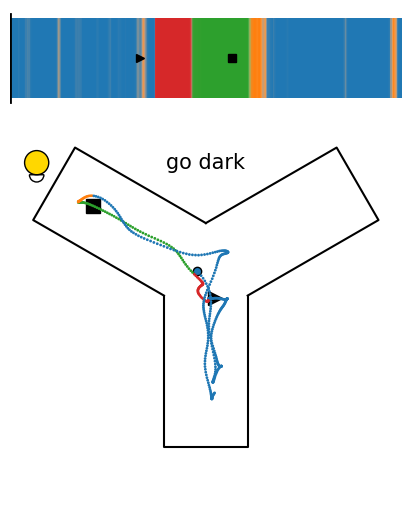

cell finished on hpc_cpu.


In [21]:
trial = 12
# trial = 18
ani = make_video(behavior.loc[trial], inferred_states_list[trial], gamma_list[trial], n_points=450)
ani.save(filename=f"{trial}.mp4", writer="ffmpeg", fps=30)

In [22]:
%stop_runtime hpc_cpu

Terminated runtime=hpc_cpu. state={'experimentId': 'CS_Agent_4c72e70d-7bab-4168-9b3e-a77d0882d3b4', 'terminated': True}
